In [2]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange
from src.latency_models import LogNormalLatency

from examples.cross_exchange_example import cross_exchange

%load_ext autoreload 
%autoreload 2

## Load data

In [3]:
dates = [f'2023-07-0{i}' for i in range(1, 5)]
# dates = [f'2023-07-02']

In [4]:
base = 'BTC'
quote = 'USDT'

folder_path = 'data_loader/datasets/'
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == base+quote+'.csv.gz'
    and f.split('_')[1] == 'quotes'
    and f.split('_')[2] in dates]

tfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == base+quote+'.csv.gz'
    and f.split('_')[1] == 'trades'
    and f.split('_')[2] in dates]

ufiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[1] == 'quotes'
    and f.split('_')[2] in dates]

utfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[1] == 'trades'
    and f.split('_')[2] in dates]

In [5]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)

    df['time'] = pd.to_datetime(df.timestamp, unit='us')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    return df

In [6]:
upbit_data = get_data(ufiles_list)
binance_data = get_data(files_list)

upbit_trades_data = get_data(utfiles_list)
binance_trades_data = get_data(tfiles_list)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


In [7]:
binance_lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
binance_trades_lst = binance_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()
upbit_lst = upbit_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
upbit_trades_lst =  upbit_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()

In [8]:
symbol = base + quote

hedging = TOB_Exchange(latency=LogNormalLatency(50000, 0.3), name='hedging')
hedging.add_market(symbol, base, quote)
hedging.add_balance(base, 1)
hedging.add_balance(quote, 0)
hedging.load_tob(binance_lst, symbol)
hedging.load_trades(binance_trades_lst, symbol)

2023-08-11 19:33:44,444 - INFO - src.exchange - hedging - Loading 2001748 TOB-Updates for BTCUSDT
2023-08-11 19:33:52,963 - INFO - src.exchange - hedging - TOB-Updates loaded successfully
2023-08-11 19:33:52,964 - INFO - src.exchange - hedging - Loading 2720833 trades for BTCUSDT
2023-08-11 19:34:11,272 - INFO - src.exchange - hedging - Trades loaded successfully


In [9]:
origin = TOB_Exchange(latency=LogNormalLatency(50000, 0.3), name='origin')
initial_quote = 30_000
origin.add_market(symbol, base, quote)
origin.add_balance(base, 0)
origin.add_balance(quote, initial_quote)
origin.load_tob(upbit_lst, symbol)
origin.load_trades(upbit_trades_lst, symbol)

2023-08-11 19:34:11,312 - INFO - src.exchange - origin - Loading 57848 TOB-Updates for BTCUSDT
2023-08-11 19:34:11,478 - INFO - src.exchange - origin - TOB-Updates loaded successfully
2023-08-11 19:34:11,478 - INFO - src.exchange - origin - Loading 1347 trades for BTCUSDT
2023-08-11 19:34:11,482 - INFO - src.exchange - origin - Trades loaded successfully


In [10]:
strategy = cross_exchange(origin=origin, hedging=hedging, initial_quote=initial_quote)
strategy.run_simulation()

2023-08-11 19:34:11,555 - INFO - src.exchange - origin - Order Opened. Order(order_id=0, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30167.28, entryTime=1688169601400327.0, eventTime=1688169601460133.0, status=<OrderStatus.OPEN: 'open'>, parentLevel=None)


2023-08-11 19:34:11,879 - INFO - src.exchange - origin - Order Cancelled. CancelOrder(symbol='BTCUSDT', order=Order(order_id=0, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30167.28, entryTime=1688169601400327.0, eventTime=1688169601460133.0, status=<OrderStatus.OPEN: 'open'>, parentLevel=None))
2023-08-11 19:34:11,880 - INFO - src.exchange - origin - Order Opened. Order(order_id=1, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30228.6501, entryTime=1688172302885206.0, eventTime=1688172302926316.0, status=<OrderStatus.OPEN: 'open'>, parentLevel=None)
2023-08-11 19:34:11,900 - INFO - src.exchange - origin - Order Cancelled. CancelOrder(symbol='BTCUSDT', order=Order(order_id=1, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30228.6501, entryTime=1688172302885206.0, eventTime=1688172302926316.0, status=<OrderStatus.OPEN: 'open'>, parentLevel=None))
2023-08-11 19:34:11,901 - INFO - src.exc

In [12]:
strategy.buy_open

True

In [13]:
origin.orders

[Order(order_id=0, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30167.28, entryTime=1688169601400327.0, eventTime=1688172302880583.0, status=<OrderStatus.CANCELLED: 'cancelled'>, parentLevel=None),
 Order(order_id=1, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30228.6501, entryTime=1688172302885206.0, eventTime=1688172498752406.0, status=<OrderStatus.CANCELLED: 'cancelled'>, parentLevel=None),
 Order(order_id=2, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.0, price=30168.0225, entryTime=1688172498752462.0, eventTime=1688172755930000, status=<OrderStatus.FILLED: 'filled'>, parentLevel=None),
 Order(order_id=6, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.0, price=30173.616, entryTime=1688172756142161.0, eventTime=1688172845898000.0, status=<OrderStatus.FILLED: 'filled'>, parentLevel=None),
 Order(order_id=8, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainin

In [14]:
bal = pd.DataFrame(strategy.balances)
bal.index = pd.to_datetime(bal.ts, unit='us')

bal['base_usd'] = bal[base] * bal.mid
bal['base_usd_hedging'] = bal.base_hedging * bal.mid
bal['combined_origin'] = bal.base_usd + bal[quote]
bal['combined_hedging'] = bal.quote_hedging + bal.base_usd_hedging

bal['bh_base'] = 0.3
bal['bh_quote'] = 10_000

In [15]:
origin.open_orders

{'BTCUSDT': {1: SortedDict({30153.42: Order(order_id=462, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30153.42, entryTime=1688311394383754.0, eventTime=1688311394437063.0, status=<OrderStatus.OPEN: 'open'>, parentLevel=None), 30162.0033: Order(order_id=460, symbol='BTCUSDT', side=1, taker=False, amount=0.01, remainingAmount=0.01, price=30162.0033, entryTime=1688311394368523.0, eventTime=1688311394392133.0, status=<OrderStatus.OPEN: 'open'>, parentLevel=None)}),
  0: SortedDict({})}}

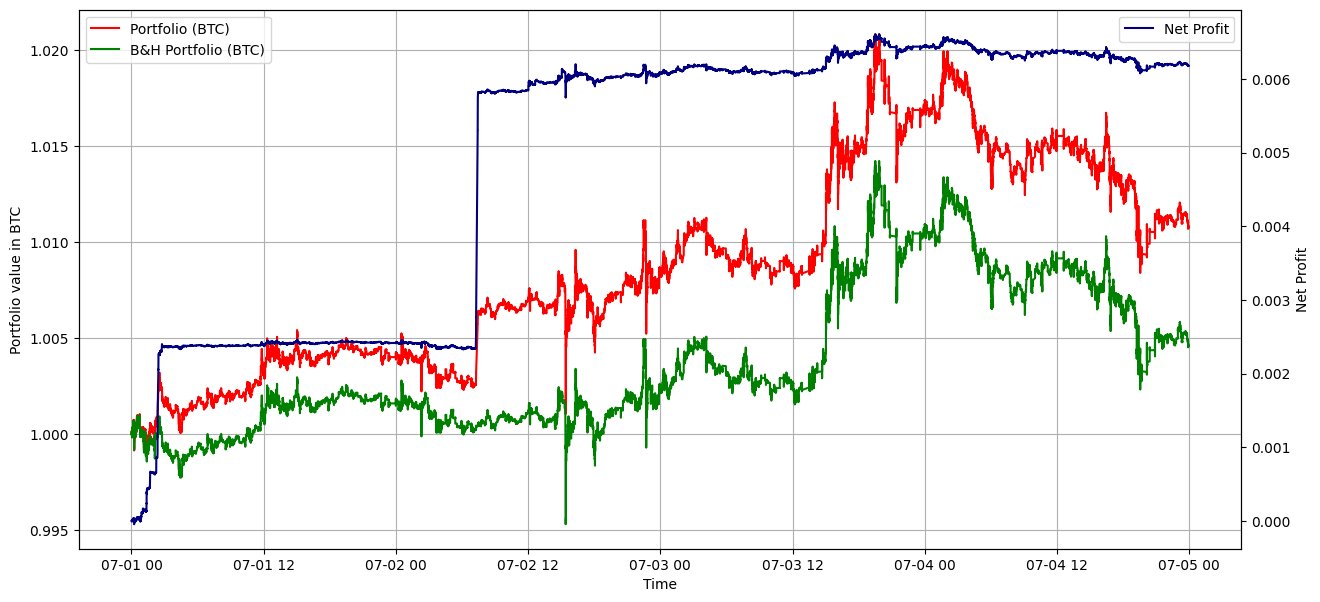

In [16]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot((1+(bal.combined_origin + bal.combined_hedging).pct_change()).cumprod(), label='Portfolio (BTC)', color='r')
ax.plot((1+(bal.bh_quote + bal.bh_base * bal.mid).pct_change()).cumprod(), label='B&H Portfolio (BTC)', color='g')

ax2 = ax.twinx()
ax2.plot((1+(bal.combined_origin + bal.combined_hedging).pct_change()).cumprod() - (1+(bal.bh_quote + bal.bh_base * bal.mid).pct_change()).cumprod(), label='Net Profit', color='navy')
#ax2.plot(bal.mid, label='COMPBTC Price')
ax.set_xlabel('Time')
ax2.set_ylabel('Net Profit')
ax.set_ylabel('Portfolio value in BTC')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.grid()

## Trade Exploration

In [17]:
binance_data.set_index('timestamp', inplace=True)
upbit_data.set_index('timestamp', inplace=True)

In [18]:
start =int(datetime(2023, 7, 1, 0, 0).timestamp() * 1_000_000)
end = int(datetime(2023, 7, 1, 3, 0).timestamp() * 1_000_000)

In [19]:
o_trades = pd.DataFrame(origin.trades)
h_trades = pd.DataFrame(hedging.trades)
orders = pd.DataFrame(origin.orders)

In [20]:
for i in [o_trades, h_trades, orders]:
    if len(i) > 0:
        i['entryTime'] = pd.to_datetime(i['entryTime'], unit='us')
        i['eventTime'] = pd.to_datetime(i['eventTime'], unit='us')

In [21]:
binance_data.index = pd.to_datetime(binance_data.index, unit='us')
upbit_data.index = pd.to_datetime(upbit_data.index, unit='us')

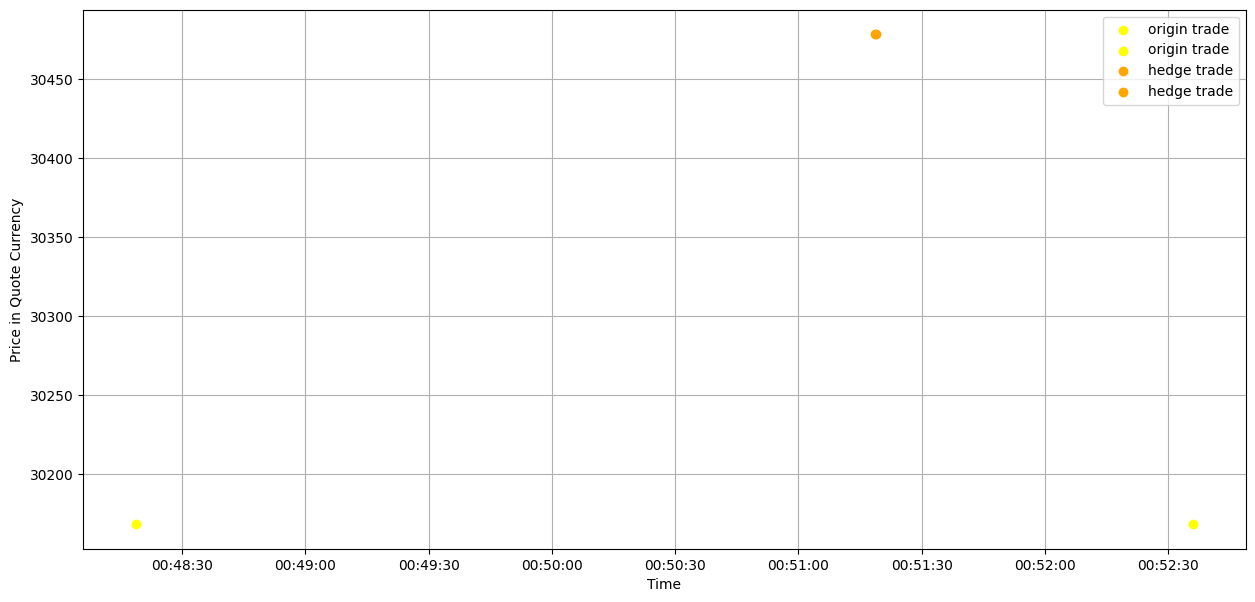

In [22]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.scatter(o_trades.entryTime[0], o_trades.price[0], color='yellow', label='origin trade')
ax.scatter(o_trades.eventTime[0], o_trades.price[0], color='yellow', label='origin trade')
ax.scatter(h_trades.entryTime[0], h_trades.price[0], color='orange', label='hedge trade')
ax.scatter(h_trades.eventTime[0], h_trades.price[0], color='orange', label='hedge trade')

ax.set_xlabel('Time')
ax.set_ylabel('Price in Quote Currency')
ax.legend(loc=1)
ax.grid()

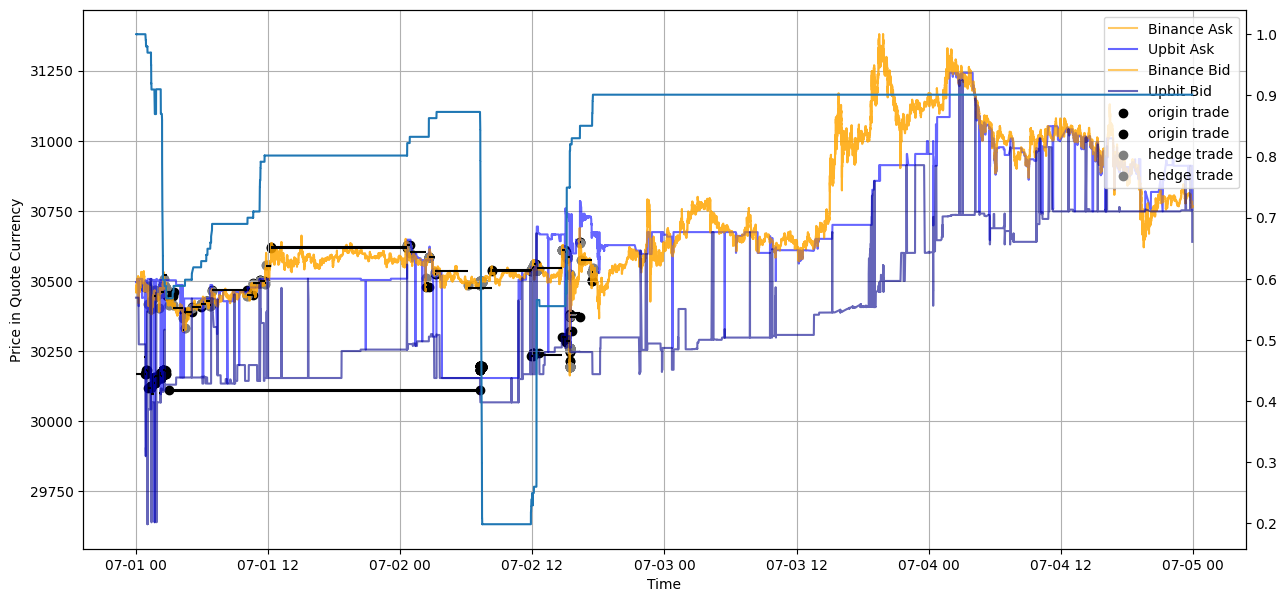

In [23]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(binance_data['ask_price'], label='Binance Ask', color='orange', alpha=0.6)
ax.plot(upbit_data['ask_price'], label='Upbit Ask', color='blue', alpha=0.6)
ax.plot(binance_data['bid_price'], label='Binance Bid', color='orange', alpha=0.6)
ax.plot(upbit_data['bid_price'], label='Upbit Bid', color='darkblue', alpha=0.6)

ax.scatter(o_trades.entryTime, o_trades.price, color='black', label='origin trade')
ax.scatter(o_trades.eventTime, o_trades.price, color='black', label='origin trade')
ax.scatter(h_trades.entryTime, h_trades.price, color='grey', label='hedge trade')
ax.scatter(h_trades.eventTime, h_trades.price, color='grey', label='hedge trade')

ax.hlines(y=orders.price, xmin=orders.entryTime, xmax=orders.eventTime, colors='black', alpha=1, linestyles='solid')

ax.set_xlabel('Time')
ax.set_ylabel('Price in Quote Currency')
ax.legend(loc=1)
ax.grid()

ax2 = ax.twinx()
ax2.plot(bal['skew'])

In [24]:
trades = pd.concat([o_trades, h_trades])
trades['volume'] = trades.price * trades.amount
trades = trades.groupby('side')[['amount', 'volume']].sum()

In [25]:
trades['vwap'] = trades.volume / trades.amount

In [26]:
trades.vwap * trades.amount

side
0    70447.279571
1    69782.207849
dtype: float64

In [27]:
trades

,amount,volume,vwap
side,,,
0,2.31,70447.279571,30496.657823
1,2.30,69782.207849,30340.090369
